# Status + LTD

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import lines
import pandas as pd
import scipy.special
from pathlib import Path
from statsmodels.graphics.tsaplots import plot_acf

In [2]:
outputs_dir_test = Path("../../outputs/LtdStatus/outputs/test")
outputs_dir = Path("../../outputs/LtdStatus/outputs/change_q")
# outputs_dir_new = Path("../../outputs/LtdStatus/outputs/n100")

# Phase transition details

In [3]:
"""These functions present analytical solutions for the model. 
The parameter `label` can be one of the two values: Adam or Piotr. 
When it is Adam the `q` parameter is as it is in the paper, that is
it is the probability of the status dynamics. 
"""


def get_pb_crit(q, ph, label="adam"):
    """
    This function doesn't check if critical value exists. One needs to check beforehand. 
    """
    if label == "adam":
        q = 1-q
    return ((2*q + (1-q)*(1-2*ph))**2 / (8*q**2) + 1)/2

def get_rho_crit(q,ph, label="adam"):
    """
    This function doesn't check if critical value exists. One needs to check beforehand. 
    Basic assumption: pb_crit>0.5
    """
    if label == "adam":
        q = 1-q
    return 2*q/(2*q + (1-q)*(1-2*ph))

def get_q_crit(pb, ph, label="adam"):
    """
    This function doesn't check if critical value exists. One needs to check beforehand. 
    Basic assumption: pb_crit>0.5
    """
    if pb < 0.5:
        return np.NaN
    rho_cr = 1/2/np.sqrt(pb-0.5)
    q_cr = 2*(1/rho_cr-1)/(2/rho_cr-2*ph-1)
    return q_cr

def get_pb_when_rho_eq_1(q, ph, label="adam"):
    """This function doesn't check if such pb exists. 

    Args:
        q (_type_): _description_
        ph (_type_): _description_
        label (str, optional): _description_. Defaults to "adam".
    """
    if label == "adam":
        q = 1-q
    return (3*q + (1-2*ph)*(1-q)) / (4*q)

def Delta(pb, ph, q, label="adam"):
    if label == "adam":
        q = 1-q
    return (2 *q + (1 -q)*(1 -2 *ph))** 2 - 4*(4 *pb *q -2 *q) *q

def afun(pb, ph, q, label="adam"):
    if label == "adam":
        q = 1-q
    return (4 *pb *q -2 *q)
def bfun(pb, ph, q, label="adam"):
    if label == "adam":
        q = 1-q
    return -2 *q - (1 -q)*(1 -2 *ph)
def cfun(pb, ph, q, label="adam"):
    if label == "adam":
        q = 1-q
    return q

def get_rhos(pb,ph,q, label="adam"):
    a = afun(pb, ph, q, label=label)
    b = bfun(pb, ph, q, label=label)
    c = cfun(pb, ph, q, label=label)
    
    if a == 0:
        return (-c / b, )
    
    d = Delta(pb, ph, q, label=label)
    if d < 0:
        if np.round(d, decimals = 15) < 0:
            return (np.nan, )
        else:
            d = np.round(d, decimals = 15)
    
    rho1 = (-b  - np.sqrt(d)) / 2 /a
    rho2 = (-b  + np.sqrt(d)) / 2 /a
    return sorted([rho1, rho2])
# rho2(pb,ph,q) = (2q + (1-q)(1-2ph) + sqrt(Delta(pb,ph,q))) / 2*(4pb*q-2q)

def get_quasi_rho(pb,ph,q, label="adam"):
    """Returns one value which is the level of quasi-stationary state if such a level exists. 
    Otherwise returns np.NaN

    Args:
        pb (_type_): _description_
        ph (_type_): _description_
        q (_type_): _description_
    """
    rhos = get_rhos(pb,ph,q, label=label)
    
    if len(rhos) == 1:
        if np.isnan(rhos[0]):
            return np.NaN
        elif (rhos[0] <= 1) & (rhos[0] >= 0):
            return rhos[0]
        else:
            return np.NaN
    
    if (rhos[0] <= 1) & (rhos[0] >= 0):
        if rhos[0] < rhos[1]: #rhos[0] is in proper range and is smaller. 
            rho_exp = rhos[0]
        elif (rhos[1] <= 1) & (rhos[1] >= 0): #rhos[1] is in proper range and is smaller. 
            rho_exp = rhos[1]
        else: #rhos[0] is in proper range and rhos[1] is not. 
            rho_exp = rhos[0]
    elif (rhos[1] <= 1) & (rhos[1] >= 0): #rhos[1] is in proper range and rhos[0] is not. 
        rho_exp = rhos[1]
    else:
        rho_exp = np.NaN
        
    return rho_exp

def get_separatrix(pbs, ph, q, label="adam"):
    """Returns rho values of separatrix (if exists) for given parameters

    Args:
        pbs (list or numpy.array): pb values
        ph (float): probabiilty ph
        q (float): probability q
    """
    
    rho_crits = np.zeros(len(pbs))
    for i, pb in enumerate(pbs):
        rhos_crit = get_rhos(pb, ph, q, label=label)
        
        no_sep_value = True
        if len(rhos_crit) == 2:
            if 0 < rhos_crit[0] < 1:
                if 0 < rhos_crit[1] < 1:
                    no_sep_value = False
                    rho_crits[i] = rhos_crit[1]
        if no_sep_value:
            rho_crits[i] = np.nan
    return rho_crits


/tmp/ipykernel_388487/1355872723.py:44: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


Text(0, 0.5, '$\\sin (\\theta)$')

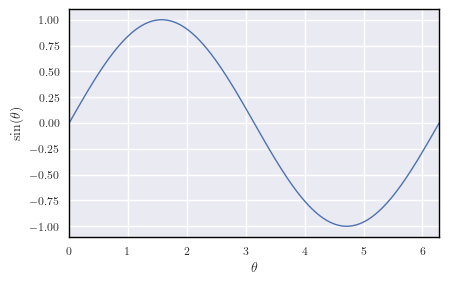

In [4]:
def set_size(width, fraction=1, subplots=(1, 1)):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float or string
            Document width in points, or string of predined document type
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    if width == 'thesis':
        width_pt = 426.79135
    elif width == 'beamer':
        width_pt = 307.28987
    else:
        width_pt = width

    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)

import numpy as np
import matplotlib.pyplot as plt

# Using seaborn's style
plt.style.use('seaborn')
width = 345
# width = 1000

tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8
}

plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1
plt.rcParams.update(tex_fonts)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 4

x = np.linspace(0, 2*np.pi, 100)
# Initialise figure instance
fig, ax = plt.subplots(1, 1, figsize=set_size(width))
# Plot
ax.plot(x, np.sin(x))
ax.set_xlim(0, 2 * np.pi)
ax.set_xlabel(r'$\theta$')
ax.set_ylabel(r'$\sin (\theta)$')



In [5]:
figsize = set_size(width)
# figsize = (figsize[0] * 1.7, figsize[1])

In [6]:
get_quasi_rho(0.9, 0.2, 0.5)

0.6249999999999999

start 0.2
nan
0.4689429556574725
start 0.8
nan
-7.549703546891171


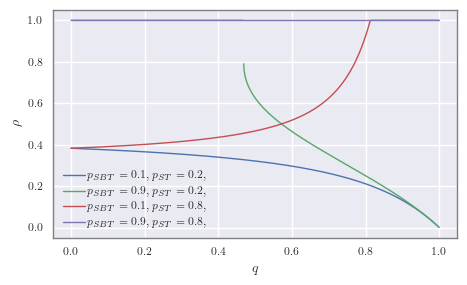

In [7]:
which_version = 2
errors = True
save_ = False

fig, axs = plt.subplots(1, 1, figsize=figsize, sharey=True)

# qs = [0.1, 0.5, 0.8]
pbs2 = [0.1,0.9]
phs = [0.2, 0.8]
# phs = [0.45, 0.5, 0.55]

# pbs = np.arange(0,1,0.001)
qs2 = np.arange(0,1,0.001)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
# markers = ["v", "x", "o"]

ax = axs
line = -1
# for i, (ax, ph) in enumerate(zip(axs, phs)):
for i, ph in enumerate(phs):
    print("start " + str(ph))
    for j, pb in enumerate( pbs2):
        line += 1
        # if line == 1:
        #     continue
        "Get anal line"
        qs2_here = np.array(qs2)
        rho_qs = np.array([get_quasi_rho(pb, ph, q) for q in qs2])
        rho_exp = np.array([rho for rho in rho_qs])
        inds = np.isnan(rho_qs)
        "Changing last True to False to break continuous lines in the case of discontinuous jumps."
        # print(inds)
        if len(np.where(inds)[0]) > 0:
            inds[np.where(inds)[0][-1]] = False
        rho_exp[inds] = 1
        
        # if line == 2:
        #     line = 2/0
        
        qc = get_q_crit(pb, ph)
        print(qc)
        rhoc = get_rho_crit(qc, ph)
        
        if (qc <= 1) & (qc >= 0):
            if (rhoc <= 1) & (rhoc >= 0):
                if not (qc in qs2):
                    rho_exp = np.insert(rho_exp, np.where(qs2 > qc)[0][0], rhoc)
                    qs2_here = np.insert(qs2, np.where(qs2 > qc)[0][0], qc)
                    
        # "Add value in rho=1, when the transition is continuous."
        # pb_rho_is_1 = get_pb_when_rho_eq_1(q, ph)
        # rho_rho_is_1_exp = get_quasi_rho(pb_rho_is_1, ph, q)
        # # print(pb_rho_is_1, rho_rho_is_1_exp)
        # if (pb_rho_is_1 >= 0) & (pb_rho_is_1 <= 1):
        #     rhos = get_rhos(pb_rho_is_1, ph, q)
        #     if np.isnan(rho_rho_is_1_exp):
        #         rho_rho_is_1_exp = rhos[0]
        #     # print(rhos)
        #     # print(rho_rho_is_1_exp)
        #     if np.abs(rho_rho_is_1_exp - 1) < 10**-10:
        #         "If unstable solution is closer, we don't care"
        #         if not (pb_rho_is_1 in pbs_here):
        #             # print(i, j)
        #             rho_exp = np.insert(rho_exp, np.where(pbs_here > pb_rho_is_1)[0][0], 1)
        #             pbs_here = np.insert(pbs_here, np.where(pbs_here > pb_rho_is_1)[0][0], pb_rho_is_1)
        
        # "Get sim vals"
        # rows = (df2_g.q == q) & ( df2_g.ps == ph)
        # inds = np.where(rows)[0]
        # xvals = [row.p for i, (index, row) in enumerate(df2_g.iterrows()) if i in inds]
        # yvals1 = np.array([row.level for i, (index, row) in enumerate(df2_g.iterrows()) if i in inds])
        # yvals1[np.isnan(yvals1)] = 1
        # yerr1 = np.array([row.level_std for i, (index, row) in enumerate(df2_g.iterrows()) if i in inds])
        # yvals2 = np.array([row.level2 for i, (index, row) in enumerate(df2_g.iterrows()) if i in inds])
        # yvals2[np.isnan(yvals2)] = 1
        # yerr2 = np.array([row.level2_std for i, (index, row) in enumerate(df2_g.iterrows()) if i in inds])
        
        label = r"$p_{{SBT}}={pb},p_{{ST}}={ph},$".format(pb=pb,ph=ph)
        ax.plot(qs2_here, rho_exp, '-', color = colors[line],label=label)#'_nolegend_')
        
        # if which_version == 1:
        #     yvals = yvals1
        #     yerr = yerr1
            
        # else:
        #     yvals = yvals2
        #     yerr = yerr2
        
        # yerr[yerr < 0.01] = np.NaN
        # yerr = list(yerr)
        
        
        # if j in [0,2]:
        #     if errors:
        #         (plotline, caplines, _) = ax.errorbar(xvals, yvals, yerr = yerr, linestyle = '', color = colors[j], marker=markers[j], label = label, elinewidth=0.5, ecolor = "k", capsize=2)
        #         plotline.set_markerfacecolor('none')
        #         plotline.set_markeredgewidth(0.5)
        #         for cap in caplines:
        #             cap.set_markeredgewidth(0.1)
        #     else:
        #         ax.scatter(xvals, yvals, color = colors[j], marker=markers[j], facecolors='none', label = label)
        # else:
        #     if errors:
        #         (plotline, caplines, _) = ax.errorbar(xvals, yvals, yerr = yerr, linestyle = '', color = colors[j], marker=markers[j], label = label, elinewidth=0.5, ecolor = "k", capsize=2)
        #         plotline.set_markeredgewidth(0.5)
        #         for cap in caplines:
        #             cap.set_markeredgewidth(0.1)
        #     else:
        #         ax.scatter(xvals, yvals, color = colors[j], marker=markers[j], label = label)
        
    ax.spines['bottom'].set_color('0.5')
    ax.spines['top'].set_color('0.5')
    ax.spines['right'].set_color('0.5')
    ax.spines['left'].set_color('0.5')
    # if i == 0:
    ax.set_ylabel(r'$\rho$')
    # elif i==2:
    ax.legend(handletextpad=0.1)
    # elif i==1:
    ax.set_xlabel(r'$q$')
    
    # ax.set_ylim([0.15, 1.05])
    # ax.set_title(r'$p_H={ph}$'.format(ph=ph))
        
# fig.supxlabel(r'$p$')

# Save and remove excess whitespace
fig.tight_layout()
if save_:
    fig.savefig('change_q3' + '.pdf', format='pdf', bbox_inches='tight') 


## Process data

In [8]:
import os, ast

def process_data(data, n_links, n_triads, k=1):
    for column in data.columns[k:-2]:
        data.loc[:, column] = data[column].str.split(',').map(lambda x: [int(float(x_el))/n_triads for x_el in x])
    data.loc[:, 'rho'] = data['rho'].str.split(',').map(lambda x: [int(float(x_el))/n_links for x_el in x])
    return data

def means_of_data(data, start, steps):
    df = pd.DataFrame(columns=data.columns)
    for _, row in data.iterrows():
        df = df.append(pd.DataFrame({
        'prob': row.p,
        'rho': row.rho[start:][::steps],
        'n0': row.n0[start:][::steps],
        'n1': row.n1[start:][::steps],
        'n2': row.n2[start:][::steps],
        'n3': row.n3[start:][::steps]
        }))
    df = df.groupby('prob').mean()
    return df

def get_rho_init(filename):
    with open(filename) as f:
        first_line = f.readline()
        spl = first_line.split("--rho-init', '")
        if len(spl) == 1:
            return 0.5
        else:
            strval = spl.split("'")[0]
            return float(strval)
        
def read_params(filename):
    params_d = {}
    with open(filename) as f:
        first_line = f.readline()
        # firstline = "# Commit: 126356fd51d619772e0c4137e13dfe116d309ebe# Arguments: ['main.py', 'LtdStatus', '-n', '100', '-p', '0.88', '-q', '0.5', '-ps', '0.25', '-s', '100', '-r', '1', '--rho-init', '0.9', '--ltd-agent-based', '--on-triad-status', 'outputs/test']"
        params = first_line.split("Arguments: ")[1]
        # params.strip('][').strip("'").split(', ')
        try:
            params = ast.literal_eval(params)
            isvalue = False
            last_key = ""
            for par in params:
                if par.startswith('--'):
                    if isvalue:
                        isvalue = False
                        # params_d[last_key] = True
                if not isvalue:
                    if par.startswith('--'):
                        par2 = par.strip("-")
                        par2 = par2.replace('-', '_')
                        params_d[par2] = True
                        isvalue = True
                        last_key = par2
                    elif par.startswith('-'):
                        par2 = par.strip("-")
                        par2 = par2.replace('-', '_')
                        params_d[par2] = np.NAN
                        isvalue = True
                        last_key = par2
                else:
                    isvalue = False
                    try:
                        if "." in par:
                            params_d[par2] = float(par)
                        else:
                            params_d[par2] = int(par)
                    except ValueError:
                        pass
        except (SyntaxError, ValueError):
            params = params.split("Namespace(")[1]
            params = params[:-1]
            params = params.split(',')
            params = list(map(lambda x: x.strip(), params))
            params = list(map(lambda x: x.split('='), params))
            keys = [param[0] for param in params]
            vals = [param[1] for param in params]
            for key, val in zip(keys, vals):
                if key == "steps":
                    key = "s"
                elif key == "n_agents":
                    key = "n"
                if val.startswith("'"):
                    params_d[key] = val
                    continue
                if val.startswith("["):
                    val = val[1:-1]
                try:
                    params_d[key] = int(val)
                except ValueError:
                    try:
                        params_d[key] = float(val)
                    except ValueError:
                        pass
                    
            
    return params_d

def process_folder(directory, no_triad_stats = True):
    files = [os.path.join(directory, dir, "outputs.tsv") for dir in os.listdir(directory)]
    
    df = pd.DataFrame({"q": [], "p": [], "ps": [], "rho_init": [], "steps": [],  "rho": [], "bp": []})
    usecols = ['q','p', 'ps', 'rho', 'bp']
    usecols_backup = ['q','p', 'ps', 'tr0', 'tr1']
    
    empty_folds = np.ones(len(files))
    reps = np.zeros(len(files), dtype = int)
    
    for i, file in enumerate(files):
        inilen = len(df)
        df2 = df.append(pd.read_csv(file,sep = '\t', comment='#', usecols = usecols))
        
        if type(np.array(df2.rho)[-1]) != str:
            if np.isnan(np.array(df2.rho)[-1]):
                """There is most likely error in columns. rho values are in another column"""
                df3 = pd.read_csv(file,sep = '\t', comment='#', usecols = usecols_backup)
                # df3.append(pd.read_csv(file,sep = '\t', comment='#', usecols = usecols_backup))
                df3_len = len(df3)
                df2_len = inilen+df3_len
                # print(df3)
                # print(df3_len)
                # print(df3.tr0.iloc[-df3_len:-1])
                # print(df3.tr0)
                # return df3, df2
                df2.loc[np.array(range(0,df2_len)) >= df2_len - df3_len, 'rho'] = df3["tr0"]
                df2.loc[np.array(range(0,df2_len)) >= df2_len - df3_len, 'bp'] = df3["tr1"]
                # print(df2)
                # for i, row in enumerate(df3.iterrows()):
                #     df2.rho.iloc[-i] = df3.tr0.iloc[-i]
                #     df2.bp.iloc[-i] = df3.tr1.iloc[-i]
        df = df2
        
        endlen = len(df)
        
        reps[i] = endlen - inilen
        
        if inilen == endlen:
            empty_folds[i] = False
    
    dicts = [read_params(file) for i, file in enumerate(files)]# if empty_folds[i] == 1]
    
    rho_inits_one = [round(d["rho_init"], 6) if "rho_init" in d else 0.5 for d in dicts]
    steps_one = [d["s"] for d in dicts]
    
    rho_inits = [rho_init for rho_init, rep in zip(rho_inits_one, reps) for _ in range(0,rep)]
    steps = [step for step, rep in zip(steps_one, reps) for _ in range(0,rep)]
    # print(df)
    # return df, rho_inits
    df.rho_init = rho_inits
    df.steps = steps
    
    df = df.dropna().reset_index()
    
    Ls_one = [d["n"]*(d["n"] - 1) for d in dicts]
    Ls = [L for L, rep in zip(Ls_one, reps) for _ in range(0,rep)]
    df.rho = np.array(df.rho.str.split(',').map(lambda x: [float(x_el) for x_el in x]))
    df["Lplus"] = df.rho
    df.rho = [np.array(rho) / L for rho, L in zip(df.rho, Ls)]
    
    return df

def group_results(df, cols):
    """group results according to (q,p,ps,rho_init,steps) anc check the outcome

    Args:
        df (_type_): _description_
    """
    mylist = dict()
    
    for group in df.groupby(cols):
        (group_label, df_temp) = group
        q = df.q[0]
        ps = df.ps[0]
        
        rho_crit = get_rho_crit(q, ps)
        
        reps = len(df_temp.rho)
        paradise = np.sum([rho[-1] == 1. for rho in df_temp.rho])
        quasi_stat = np.sum([rho[-1] < rho_crit for rho in df_temp.rho])
        other = np.array(reps) - paradise - quasi_stat
        
        paradise_ratio = paradise / (paradise + quasi_stat)
        
        d = dict(zip(cols, group_label))
        
        d.update({"repetitions": reps, "paradise": paradise, "quasi_stat": quasi_stat, "other": other, "paradise_ratio": paradise_ratio})
        mylist.update({group_label: d})
    
    return pd.DataFrame(data = mylist.values(), index = mylist.keys(), columns = [*cols, 'repetitions', 'paradise', 'quasi_stat', 'other', 'paradise_ratio'])
    

In [9]:
# df, rho_inits = process_folder(outputs_dir_test)
df = process_folder(outputs_dir)
df

,index,q,p,ps,rho_init,steps,rho,bp,Lplus
0,0,0.00,0.1,0.2,0.5,400,"[0.49313131313131314, 0.4036363636363636, 0.38...",2610.0,"[4882.0, 3996.0, 3837.0, 3844.0, 3786.0, 3799...."
1,1,0.00,0.1,0.2,0.5,400,"[0.5005050505050505, 0.3996969696969697, 0.381...",2671.0,"[4955.0, 3957.0, 3777.0, 3791.0, 3811.0, 3709...."
2,2,0.00,0.1,0.2,0.5,400,"[0.501010101010101, 0.40424242424242424, 0.386...",2601.0,"[4960.0, 4002.0, 3824.0, 3750.0, 3808.0, 3721...."
3,3,0.00,0.1,0.2,0.5,400,"[0.5053535353535353, 0.3997979797979798, 0.384...",2666.0,"[5003.0, 3958.0, 3808.0, 3791.0, 3846.0, 3787...."
4,4,0.00,0.1,0.2,0.5,400,"[0.49464646464646467, 0.4003030303030303, 0.37...",2644.0,"[4897.0, 3963.0, 3732.0, 3777.0, 3792.0, 3812...."
...,...,...,...,...,...,...,...,...,...
10095,95,0.65,0.2,0.8,0.5,400,"[0.49676767676767675, 0.5356565656565656, 0.55...",2504.0,"[4918.0, 5303.0, 5525.0, 5707.0, 5799.0, 5850...."
10096,96,0.65,0.2,0.8,0.5,400,"[0.5073737373737374, 0.5487878787878788, 0.567...",2564.0,"[5023.0, 5433.0, 5616.0, 5768.0, 5792.0, 5821...."
10097,97,0.65,0.2,0.8,0.5,400,"[0.4998989898989899, 0.5286868686868686, 0.558...",2603.0,"[4949.0, 5234.0, 5534.0, 5665.0, 5758.0, 5796...."
10098,98,0.65,0.2,0.8,0.5,400,"[0.4954545454545455, 0.5309090909090909, 0.558...",2537.0,"[4905.0, 5256.0, 5528.0, 5694.0, 5721.0, 5795...."


In [10]:
df_g = group_results(df, ['q', 'p', 'ps', 'rho_init'])
df_g

q    p   ps  rho_init  repetitions  paradise  quasi_stat  \
0.0 0.1 0.2 0.5  0.0  0.1  0.2       0.5          100         0         100   
        0.8 0.5  0.0  0.1  0.8       0.5          100         0         100   
    0.2 0.2 0.5  0.0  0.2  0.2       0.5          100         0         100   
        0.8 0.5  0.0  0.2  0.8       0.5          100         0         100   
    0.8 0.2 0.5  0.0  0.8  0.2       0.5          100       100           0   
...              ...  ...  ...       ...          ...       ...         ...   
1.0 0.2 0.8 0.5  1.0  0.2  0.8       0.5          100       100           0   
    0.8 0.2 0.5  1.0  0.8  0.2       0.5          100         0         100   
        0.8 0.5  1.0  0.8  0.8       0.5          100       100           0   
    0.9 0.2 0.5  1.0  0.9  0.2       0.5          100         0         100   
        0.8 0.5  1.0  0.9  0.8       0.5          100       100           0   

                 other  paradise_ratio  
0.0 0.1 0.2 0.5      0             0.0  
        0.8 0.5      0             0.0  
    0.2 0.2 0.5      0             0.0  
        0.8 0.5      0             0.0  
    0.8 0.2 0.5      0             1.0  
...                ...             ...  
1.0 0.2 0.8 0.5      0             1.0  
    0.8 0.2 0.5      0             0.0  
        0.8 0.5      0             1.0  
    0.9 0.2 0.5      0             0.0  
        0.8 0.5      0             1.0  

[101 rows x 9 columns]

In [56]:
rho_univals = np.unique([rho for rhos in df.rho for rho in rhos])
len(rho_univals), min(rho_univals), max(rho_univals)

(4637, 0.4956565656565657, 1.0)

In [57]:
L = 100*99
vals = np.arange(min(rho_univals),max(rho_univals)+1/L,1/L)

np.max([np.min(np.abs(vals - val)) for val in rho_univals])

3.3306690738754696e-15

## Finding quasi-stationary level

In [58]:
def movingaverage(interval, window_size):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

def get_zero_crossing(vals):
    zero_crossings = np.where(np.diff(np.sign(vals)))[0]
    return zero_crossings
    

In [90]:

def get_quasilevel_exp(rho, rho_exp):
    
    if np.isnan(rho_exp):
        return get_quasilevel(rho)
    
    crossing = get_zero_crossing(rho - rho_exp)
    if len(crossing) >= 1:
        beg = crossing[0]
    else:
        return np.NaN, np.NaN, np.NaN, np.NaN
    
    beg = int(beg - np.sqrt(beg))
    if beg < 0:
        beg = 0

    fin = len(rho)

    m = np.mean(rho[beg:fin])
    s = np.std(rho[beg:fin])
    
    # tt = []
    while not ((m - s <= rho[fin-1]) & ( rho[fin-1] <= m + s )):
        fin -= 1
        m = np.mean(rho[beg:fin])
        s = np.std(rho[beg:fin])
        # tt.append((m, s, fin))
    
    return m, s, beg, fin

def get_quasilevel(rho, ini_beg = "half"):
    is_correct = False

    if ini_beg == "half":
        beg = int(len(rho) / 2)
    else:
        beg = 0
    fin = len(rho)

    m = np.mean(rho[beg:fin])
    s = np.std(rho[beg:fin])

    is_correct_beg = ((m - s <= rho[beg]) & ( rho[beg] <= m + s ))
    is_correct_fin = ((m - s <= rho[fin-1]) & ( rho[fin-1] <= m + s ))

    is_correct = is_correct_beg & is_correct_fin

    while not is_correct:
        if np.abs(rho[beg] - m) > np.abs(rho[fin-1] - m):
            beg += 1
        else:
            fin -= 1
        
        if beg == fin:
            return np.NaN, np.NaN, np.NaN, np.NaN
        
        m = np.mean(rho[beg:fin])
        s = np.std(rho[beg:fin])

        is_correct_beg = ((m - s < rho[beg]) & ( rho[beg] < m + s ))
        is_correct_fin = ((m - s < rho[fin-1]) & ( rho[fin-1] < m + s ))

        is_correct = is_correct_beg & is_correct_fin
        
    return m, s, beg, fin

def get_quasilevels(df):
    """Automatically finds average values for quasi-stationary state. If it cannot find such a state then, NaN values are given. 

    Args:
        df (_type_): _description_

    Returns:
        _type_: _description_
    """
    df2 = df.copy(deep = True)
    
    ms = np.zeros(len(df2.index))
    ss = np.zeros(len(df2.index))
    begs = np.zeros(len(df2.index))
    fins = np.zeros(len(df2.index))
    
    ms2 = np.zeros(len(df2.index))
    ss2 = np.zeros(len(df2.index))
    begs2 = np.zeros(len(df2.index))
    fins2 = np.zeros(len(df2.index))
    
    for ind, row in df2.iterrows():
        q = row.q
        psb = row.p
        ps = row.ps
        
        rho_exp = get_quasi_rho(psb,ps,q)
        
        m, s, beg, fin = get_quasilevel_exp(row.rho, rho_exp)
        ms2[ind] = m
        ss2[ind] = s
        begs2[ind] = beg
        fins2[ind] = fin
        
        m, s, beg, fin = get_quasilevel(row.rho)
        ms[ind] = m
        ss[ind] = s
        begs[ind] = beg
        fins[ind] = fin
    df2['qs_m'] = ms
    df2['qs_s'] = ss
    df2['qs_b'] = begs
    df2['qs_f'] = fins
    df2['qs2_m'] = ms2
    df2['qs2_s'] = ss2
    df2['qs2_b'] = begs2
    df2['qs2_f'] = fins2
    return df2
  
def group_quasilevels(df, cols = ['q', 'p', 'ps']):
    mylist = dict()
    
    for group in df.groupby(cols):
        (group_label, df_temp) = group
        q, psb, ps = group_label
        # q = df_temp.q
        # ps = df_temp.ps
        # psb = df_temp.p
        
        rho_exp = get_quasi_rho(psb,ps,q)
        
        reps = len(df_temp.rho)
        
        to_average = np.sum([not ((np.isnan(val)) | (val == 1)) for val in df_temp.qs_m])
        level = np.mean([val for val in df_temp.qs_m if not ((np.isnan(val)) | (val == 1))])
        level_std = np.std([val for val in df_temp.qs_m if not ((np.isnan(val)) | (val == 1))])
        
        
        to_average2 = np.sum([not ((np.isnan(val)) | (val == 1)) for val in df_temp.qs2_m])
        level2 = np.mean([val for val in df_temp.qs2_m if not ((np.isnan(val)) | (val == 1))])
        level2_std = np.std([val for val in df_temp.qs2_m if not ((np.isnan(val)) | (val == 1))])
        
        d = dict(zip(cols, group_label))
        
        d.update({"repetitions": reps, "level": level, "level_std": level_std, "level_valid": to_average, "level2": level2, "level2_std": level2_std, "level2_valid": to_average2, "level_exp" : rho_exp})
        mylist.update({group_label: d})
    
    return pd.DataFrame(data = mylist.values(), index = mylist.keys(), columns = [*cols, 'repetitions', 'level', 'level_std', 'level_valid', 'level2', 'level2_std', 'level2_valid', 'level_exp'])
    

In [94]:
df2 = get_quasilevels(df)
df2

,index,q,p,ps,rho_init,steps,rho,bp,Lplus,qs_m,qs_s,qs_b,qs_f,qs2_m,qs2_s,qs2_b,qs2_f
0,0,1.00,0.8,0.2,0.5,400,"[0.5009090909090909, 0.3606060606060606, 0.232...",4950.0,"[4959.0, 3570.0, 2298.0, 1419.0, 816.0, 449.0,...",0.000000,0.000000,200.0,400.0,0.000008,0.000075,12.0,400.0
1,1,1.00,0.8,0.2,0.5,400,"[0.49414141414141416, 0.3490909090909091, 0.23...",4950.0,"[4892.0, 3456.0, 2302.0, 1444.0, 886.0, 517.0,...",0.000000,0.000000,200.0,400.0,0.000005,0.000057,11.0,400.0
2,2,1.00,0.8,0.2,0.5,400,"[0.49777777777777776, 0.3487878787878788, 0.22...",4950.0,"[4928.0, 3453.0, 2267.0, 1395.0, 803.0, 474.0,...",0.000000,0.000000,200.0,400.0,0.000008,0.000079,12.0,400.0
3,3,1.00,0.8,0.2,0.5,400,"[0.5006060606060606, 0.3526262626262626, 0.231...",4950.0,"[4956.0, 3491.0, 2295.0, 1445.0, 862.0, 514.0,...",0.000000,0.000000,200.0,400.0,0.000005,0.000052,11.0,400.0
4,4,1.00,0.8,0.2,0.5,400,"[0.5061616161616161, 0.3572727272727273, 0.235...",4950.0,"[5011.0, 3537.0, 2328.0, 1444.0, 830.0, 461.0,...",0.000000,0.000000,200.0,400.0,0.000027,0.000326,9.0,400.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5695,95,0.65,0.2,0.8,0.5,400,"[0.49676767676767675, 0.5356565656565656, 0.55...",2504.0,"[4918.0, 5303.0, 5525.0, 5707.0, 5799.0, 5850....",0.610565,0.007358,200.0,400.0,0.610506,0.006830,8.0,400.0
5696,96,0.65,0.2,0.8,0.5,400,"[0.5073737373737374, 0.5487878787878788, 0.567...",2564.0,"[5023.0, 5433.0, 5616.0, 5768.0, 5792.0, 5821....",0.611912,0.006901,200.0,400.0,0.611648,0.006980,9.0,400.0
5697,97,0.65,0.2,0.8,0.5,400,"[0.4998989898989899, 0.5286868686868686, 0.558...",2603.0,"[4949.0, 5234.0, 5534.0, 5665.0, 5758.0, 5796....",0.612795,0.007163,201.0,399.0,0.611833,0.007296,6.0,393.0
5698,98,0.65,0.2,0.8,0.5,400,"[0.4954545454545455, 0.5309090909090909, 0.558...",2537.0,"[4905.0, 5256.0, 5528.0, 5694.0, 5721.0, 5795....",0.611357,0.007704,200.0,400.0,0.611712,0.007500,25.0,400.0


In [95]:
df2_g = group_quasilevels(df2)
df2_g

/home/pgorski/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/pgorski/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/pgorski/.local/lib/python3.8/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/pgorski/.local/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/pgorski/.local/lib/python3.8/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


q    p   ps  repetitions     level  level_std  \
0.0000 0.2 0.2  0.0000  0.2  0.2          100  0.402445   0.000282   
           0.8  0.0000  0.2  0.8          100  0.402445   0.000282   
       0.8 0.2  0.0000  0.8  0.2          100       NaN        NaN   
           0.8  0.0000  0.8  0.8          100       NaN        NaN   
0.1000 0.2 0.2  0.1000  0.2  0.2          100  0.393598   0.000321   
           0.8  0.1000  0.2  0.8          100  0.411837   0.000354   
       0.8 0.2  0.1000  0.8  0.2          100       NaN        NaN   
           0.8  0.1000  0.8  0.8          100       NaN        NaN   
0.2000 0.2 0.2  0.2000  0.2  0.2          100  0.382982   0.000344   
           0.8  0.2000  0.2  0.8          100  0.423849   0.000431   
       0.8 0.2  0.2000  0.8  0.2          100  0.997617   0.001208   
           0.8  0.2000  0.8  0.8          100       NaN        NaN   
0.2200 0.8 0.2  0.2200  0.8  0.2          100  0.995270   0.007575   
0.2400 0.8 0.2  0.2400  0.8  0.2          100  0.916877   0.034358   
0.2415 0.8 0.2  0.2415  0.8  0.2          100  0.898509   0.039364   
0.2420 0.8 0.2  0.2420  0.8  0.2          100  0.890148   0.030826   
0.2450 0.8 0.2  0.2450  0.8  0.2          100  0.870836   0.031693   
0.2500 0.8 0.2  0.2500  0.8  0.2          100  0.842976   0.019642   
0.2600 0.8 0.2  0.2600  0.8  0.2          100  0.801569   0.010117   
0.2800 0.8 0.2  0.2800  0.8  0.2          100  0.753418   0.005155   
0.3000 0.2 0.2  0.3000  0.2  0.2          100  0.370026   0.000380   
           0.8  0.3000  0.2  0.8          100  0.440272   0.000494   
       0.8 0.2  0.3000  0.8  0.2          100  0.717049   0.004740   
           0.8  0.3000  0.8  0.8          100       NaN        NaN   
0.4000 0.2 0.2  0.4000  0.2  0.2          100  0.353921   0.000379   
           0.8  0.4000  0.2  0.8          100  0.463751   0.000585   
       0.8 0.2  0.4000  0.8  0.2          100  0.593463   0.001740   
           0.8  0.4000  0.8  0.8          100       NaN        NaN   
0.5000 0.2 0.2  0.5000  0.2  0.2          100  0.333439   0.000352   
           0.8  0.5000  0.2  0.8          100  0.499600   0.000673   
       0.8 0.2  0.5000  0.8  0.2          100  0.501362   0.001329   
           0.8  0.5000  0.8  0.8          100       NaN        NaN   
0.6000 0.2 0.2  0.6000  0.2  0.2          100  0.306382   0.000414   
           0.8  0.6000  0.2  0.8          100  0.561166   0.000958   
       0.8 0.2  0.6000  0.8  0.2          100  0.418206   0.000866   
           0.8  0.6000  0.8  0.8          100       NaN        NaN   
0.6500 0.2 0.8  0.6500  0.2  0.8          100  0.611902   0.001143   
0.6750 0.2 0.8  0.6750  0.2  0.8          100  0.646119   0.001460   
0.7000 0.2 0.2  0.7000  0.2  0.2          100  0.269075   0.000436   
           0.8  0.7000  0.2  0.8          100  0.689796   0.001873   
       0.8 0.2  0.7000  0.8  0.2          100  0.334875   0.000864   
           0.8  0.7000  0.8  0.8          100       NaN        NaN   
0.7250 0.2 0.8  0.7250  0.2  0.8          100  0.746798   0.002522   
0.7500 0.2 0.8  0.7500  0.2  0.8          100  0.824808   0.003565   
0.7750 0.2 0.8  0.7750  0.2  0.8          100  0.935493   0.007159   
0.8000 0.2 0.2  0.8000  0.2  0.2          100  0.215335   0.000517   
           0.8  0.8000  0.2  0.8          100  0.999513   0.000000   
       0.8 0.2  0.8000  0.8  0.2          100  0.244833   0.000690   
           0.8  0.8000  0.8  0.8          100       NaN        NaN   
0.9000 0.2 0.2  0.9000  0.2  0.2          100  0.132852   0.000437   
           0.8  0.9000  0.2  0.8          100       NaN        NaN   
       0.8 0.2  0.9000  0.8  0.2          100  0.139014   0.000521   
           0.8  0.9000  0.8  0.8          100       NaN        NaN   
1.0000 0.2 0.2  1.0000  0.2  0.2          100  0.000000   0.000000   
           0.8  1.0000  0.2  0.8          100       NaN        NaN   
       0.8 0.2  1.0000  0.8  0.2          100  0.000000   0.000000   
           0.8  1.0000  0.8  0.

Text(0, 0.5, '$\\sin (\\theta)$')

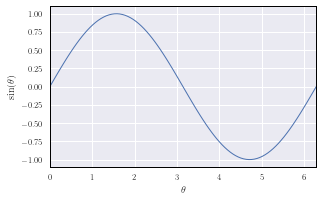

In [19]:
def set_size(width, fraction=1, subplots=(1, 1)):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float or string
            Document width in points, or string of predined document type
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    if width == 'thesis':
        width_pt = 426.79135
    elif width == 'beamer':
        width_pt = 307.28987
    else:
        width_pt = width

    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)

import numpy as np
import matplotlib.pyplot as plt

# Using seaborn's style
plt.style.use('seaborn')
width = 345
# width = 1000

tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8
}

plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1
plt.rcParams.update(tex_fonts)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 4

x = np.linspace(0, 2*np.pi, 100)
# Initialise figure instance
fig, ax = plt.subplots(1, 1, figsize=set_size(width))
# Plot
ax.plot(x, np.sin(x))
ax.set_xlim(0, 2 * np.pi)
ax.set_xlabel(r'$\theta$')
ax.set_ylabel(r'$\sin (\theta)$')



In [29]:
figsize = set_size(width)
figsize = (figsize[0] * 1.7, figsize[1])

start 0.2
nan
0.24136121900971902
start 0.8
nan
-0.4665990500063268
start 0.2
start 0.8


/home/pgorski/.local/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/pgorski/.local/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


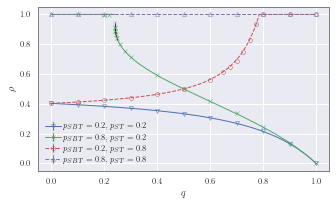

In [105]:
which_version = 2
errors = True
save_ = True

fig, axs = plt.subplots(1, 1, figsize=figsize, sharey=True)

# qs = [0.1, 0.5, 0.8]
pbs2 = [0.2,0.8]
phs = [0.2, 0.8]

# pbs = np.arange(0,1,0.001)
qs2 = np.arange(0,1,0.001)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
markers = ["v", "x", "o", "^"]
lstyles = ["-", "--"]

ax = axs
line = -1
# for i, (ax, ph) in enumerate(zip(axs, phs)):
for i, ph in enumerate(phs):
    print("start " + str(ph))
    for j, pb in enumerate( pbs2):
        line += 1
        # if line == 1:
        #     continue
        "Get anal line"
        qs2_here = np.array(qs2)
        rho_qs = np.array([get_quasi_rho(pb, ph, q) for q in qs2])
        rho_exp = np.array([rho for rho in rho_qs])
        inds = np.isnan(rho_qs)
        "Changing last True to False to break continuous lines in the case of discontinuous jumps."
        # print(inds)
        if len(np.where(inds)[0]) > 0:
            inds[np.where(inds)[0][-1]] = False
        rho_exp[inds] = 1
        
        # if line == 2:
        #     line = 2/0
        
        qc = get_q_crit(pb, ph)
        print(qc)
        rhoc = get_rho_crit(qc, ph)
        
        if (qc <= 1) & (qc >= 0):
            if (rhoc <= 1) & (rhoc >= 0):
                if not (qc in qs2):
                    rho_exp = np.insert(rho_exp, np.where(qs2 > qc)[0][0], rhoc)
                    qs2_here = np.insert(qs2, np.where(qs2 > qc)[0][0], qc)
                    
        # "Add value in rho=1, when the transition is continuous."
        # pb_rho_is_1 = get_pb_when_rho_eq_1(q, ph)
        # rho_rho_is_1_exp = get_quasi_rho(pb_rho_is_1, ph, q)
        # # print(pb_rho_is_1, rho_rho_is_1_exp)
        # if (pb_rho_is_1 >= 0) & (pb_rho_is_1 <= 1):
        #     rhos = get_rhos(pb_rho_is_1, ph, q)
        #     if np.isnan(rho_rho_is_1_exp):
        #         rho_rho_is_1_exp = rhos[0]
        #     # print(rhos)
        #     # print(rho_rho_is_1_exp)
        #     if np.abs(rho_rho_is_1_exp - 1) < 10**-10:
        #         "If unstable solution is closer, we don't care"
        #         if not (pb_rho_is_1 in pbs_here):
        #             # print(i, j)
        #             rho_exp = np.insert(rho_exp, np.where(pbs_here > pb_rho_is_1)[0][0], 1)
        #             pbs_here = np.insert(pbs_here, np.where(pbs_here > pb_rho_is_1)[0][0], pb_rho_is_1)
        
        "Get sim vals"
        rows = (df2_g.p == pb) & ( df2_g.ps == ph)
        inds = np.where(rows)[0]
        xvals = [row.q for i, (index, row) in enumerate(df2_g.iterrows()) if i in inds]
        yvals1 = np.array([row.level for i, (index, row) in enumerate(df2_g.iterrows()) if i in inds])
        yvals1[np.isnan(yvals1)] = 1
        yerr1 = np.array([row.level_std for i, (index, row) in enumerate(df2_g.iterrows()) if i in inds])
        yvals2 = np.array([row.level2 for i, (index, row) in enumerate(df2_g.iterrows()) if i in inds])
        yvals2[np.isnan(yvals2)] = 1
        yerr2 = np.array([row.level2_std for i, (index, row) in enumerate(df2_g.iterrows()) if i in inds])
        
        label = r"$p_{{SBT}}={pb},p_{{ST}}={ph}$".format(pb=pb,ph=ph)
        ax.plot(qs2_here, rho_exp, lstyles[i], color = colors[line],label= '_nolegend_')
        
        if which_version == 1:
            yvals = yvals1
            yerr = yerr1
            
        else:
            yvals = yvals2
            yerr = yerr2
        
        yerr[yerr < 0.01] = np.NaN
        yerr = list(yerr)
        
        
        if line in [0,2,3]:
            if errors:
                (plotline, caplines, _) = ax.errorbar(xvals, yvals, yerr = yerr, linestyle = '', color = colors[line], marker=markers[line], label = '_nolegend_', elinewidth=0.5, ecolor = "k", capsize=2)
                plotline.set_markerfacecolor('none')
                plotline.set_markeredgewidth(0.5)
                for cap in caplines:
                    cap.set_markeredgewidth(0.1)
            else:
                ax.scatter(xvals, yvals, color = colors[line], marker=markers[line], facecolors='none', label = '_nolegend_')
        else:
            if errors:
                (plotline, caplines, _) = ax.errorbar(xvals, yvals, yerr = yerr, linestyle = '', color = colors[line], marker=markers[line], label = '_nolegend_', elinewidth=0.5, ecolor = "k", capsize=2)
                plotline.set_markeredgewidth(0.5)
                for cap in caplines:
                    cap.set_markeredgewidth(0.1)
            else:
                ax.scatter(xvals, yvals, color = colors[line], marker=markers[line], label = '_nolegend_')
        
    ax.spines['bottom'].set_color('0.5')
    ax.spines['top'].set_color('0.5')
    ax.spines['right'].set_color('0.5')
    ax.spines['left'].set_color('0.5')
    # if i == 0:
    ax.set_ylabel(r'$\rho$')
    # elif i==2:
    # ax.legend(handletextpad=0.1)
    # elif i==1:
    ax.set_xlabel(r'$q$')
    
    # ax.set_ylim([0.15, 1.05])
    # ax.set_title(r'$p_H={ph}$'.format(ph=ph))
        
xlim = ax.get_xlim()
ylim = ax.get_ylim()

"""Adding artificial lines for legend"""
line = -1
art_x = [0.5, 0.75]
art_y = [2, 4]
art_err = [0.1, 0.1]
# for i, (ax, ph) in enumerate(zip(axs, phs)):
for i, ph in enumerate(phs):
    print("start " + str(ph))
    for j, pb in enumerate( pbs2):
        line += 1
        label = r"$p_{{SBT}}={pb},p_{{ST}}={ph}$".format(pb=pb,ph=ph)
        if line in [0,2,3]:
            if errors:
                (plotline, caplines, _) = ax.errorbar(art_x, art_y, yerr = art_err, linestyle = lstyles[i], color = colors[line], marker=markers[line], label = label, elinewidth=0.5, ecolor = "k", capsize=2)
                plotline.set_markerfacecolor('none')
                plotline.set_markeredgewidth(0.5)
                for cap in caplines:
                    cap.set_markeredgewidth(0.1)
            else:
                ax.scatter(art_x, art_y, linestyle = lstyles[i], color = colors[line], marker=markers[line], facecolors='none', label = label)
        else:
            if errors:
                (plotline, caplines, _) = ax.errorbar(art_x, art_y, yerr = art_err, linestyle = lstyles[i], color = colors[line], marker=markers[line], label = label, elinewidth=0.5, ecolor = "k", capsize=2)
                plotline.set_markeredgewidth(0.5)
                for cap in caplines:
                    cap.set_markeredgewidth(0.1)
            else:
                ax.scatter(art_x, art_y, linestyle = lstyles[i], color = colors[line], marker=markers[line], label = label)
        
ax.legend(handletextpad=0.1)         
ax.set_ylim(ylim)
ax.set_xlim(xlim)
# fig.supxlabel(r'$p$')

# Save and remove excess whitespace
fig.tight_layout()
if save_:
    fig.savefig('change_q_data2' + '.pdf', format='pdf', bbox_inches='tight') 


In [68]:
pb = ph = 0.2
rows = (df2_g.p == pb) & ( df2_g.ps == ph)
df2_g

q      p    ps  repetitions     level  level_std  \
0.5 0.800 0.25  0.5  0.800  0.25            2  0.540326   0.003828   
    0.830 0.25  0.5  0.830  0.25          200  0.575810   0.002134   
    0.840 0.25  0.5  0.840  0.25          200  0.590324   0.002435   
    0.850 0.25  0.5  0.850  0.25          202  0.607364   0.002830   
    0.860 0.25  0.5  0.860  0.25          200  0.627559   0.003324   
    0.870 0.25  0.5  0.870  0.25          201  0.652923   0.004127   
    0.875 0.25  0.5  0.875  0.25            1  0.680890   0.000000   
    0.880 0.25  0.5  0.880  0.25         1367  0.696430   0.042701   
    0.881 0.25  0.5  0.881  0.25         1106  0.703950   0.050052   
    0.882 0.25  0.5  0.882  0.25         1104  0.715522   0.065158   
    0.883 0.25  0.5  0.883  0.25         1109  0.726064   0.073584   
    0.884 0.25  0.5  0.884  0.25         1300  0.752502   0.096850   
    0.885 0.25  0.5  0.885  0.25         1100  0.761715   0.098419   
    0.886 0.25  0.5  0.886  0.25         1100  0.783162   0.106532   
    0.887 0.25  0.5  0.887  0.25         1300  0.806215   0.113439   
    0.888 0.25  0.5  0.888  0.25         1200  0.837062   0.116645   
    0.889 0.25  0.5  0.889  0.25         1209  0.868295   0.114557   
    0.890 0.25  0.5  0.890  0.25         1775  0.894572   0.104608   

                level_valid    level2  level2_std  level2_valid  level_exp  
0.5 0.800 0.25            2  0.540401    0.003264             2   0.539934  
    0.830 0.25          200  0.575941    0.001383           200   0.573907  
    0.840 0.25          200  0.590446    0.001818           200   0.588235  
    0.850 0.25          202  0.607310    0.002126           202   0.604919  
    0.860 0.25          200  0.627654    0.002425           200   0.625000  
    0.870 0.25          201  0.653348    0.002898           201   0.650522  
    0.875 0.25            1  0.680496    0.000000             1   0.666667  
    0.880 0.25         1354  0.690077    0.005172          1325   0.686740  
    0.881 0.25         1080  0.694779    0.005736          1046   0.691461  
    0.882 0.25         1060  0.699497    0.006033           999   0.696504  
    0.883 0.25         1031  0.704645    0.006212           947   0.701930  
    0.884 0.25         1153  0.710747    0.007394           971   0.707820  
    0.885 0.25          915  0.717400    0.007764           756   0.714286  
    0.886 0.25          848  0.725062    0.008948           648   0.721493  
    0.887 0.25          878  0.732738    0.010496           614   0.729705  
    0.888 0.25          679  0.742466    0.012438           403   0.739388  
    0.889 0.25          559  0.753400    0.014586           271   0.751528  
    0.890 0.25          706  0.770988    0.017958           279   0.769231

In [398]:
ps = np.array([p for p in df2_g.p[(df2_g.q == 0.8) & (df2_g.ps==0.8)]])
ps

array([0.  , 0.03, 0.06, 0.09, 0.12, 0.15, 0.2 , 0.3 , 0.4 , 0.5 , 0.6 ,
       0.7 , 0.8 , 0.9 , 1.  ])

In [77]:
inds = (df2_g.q == 1.) & (df2_g.ps==0.2) & (df2_g.p == 0.2)

df2_g[inds]

,,,q,p,ps,repetitions,level,level_std,level_valid,level2,level2_std,level2_valid,level_exp
1.0,0.2,0.2,1.0,0.2,0.2,100,NaN,NaN,0,NaN,NaN,0,0.0


In [78]:
inds = (df2.q == 1.) & (df2.ps==0.2) & (df2.p == 0.2)

# df2_g.rho[inds]
# df2.fin[inds]
df2[['q', 'p', 'ps', 'rho', 
       'qs_m', 'qs_s', 'qs_b', 'qs_f', 'qs2_m', 'qs2_s', 'qs2_b', 'qs2_f']][inds]

,q,p,ps,rho,qs_m,qs_s,qs_b,qs_f,qs2_m,qs2_s,qs2_b,qs2_f
1100,1.0,0.2,0.2,"[0.5018181818181818, 0.3593939393939394, 0.236...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1101,1.0,0.2,0.2,"[0.51, 0.3621212121212121, 0.2404040404040404,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1102,1.0,0.2,0.2,"[0.49656565656565654, 0.3481818181818182, 0.22...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1103,1.0,0.2,0.2,"[0.49676767676767675, 0.3560606060606061, 0.23...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1104,1.0,0.2,0.2,"[0.503030303030303, 0.36323232323232324, 0.244...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1195,1.0,0.2,0.2,"[0.4922222222222222, 0.35434343434343435, 0.23...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1196,1.0,0.2,0.2,"[0.5032323232323233, 0.35797979797979795, 0.23...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1197,1.0,0.2,0.2,"[0.49818181818181817, 0.35373737373737374, 0.2...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1198,1.0,0.2,0.2,"[0.5012121212121212, 0.36414141414141415, 0.23...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


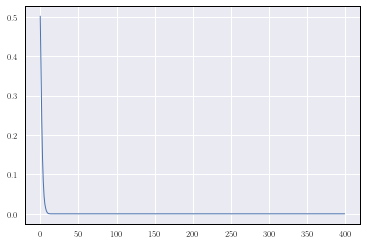

In [79]:

df_one = df2.iloc[1100].rho
df_one
plt.plot(df_one)

In [93]:
rho_exp = 0.
# m, s, b, f, tt = 
get_quasilevel_exp(df_one, rho_exp)

# m - s, m + s, df_one[b]

(1.6275284817484307e-05, 0.00021215436933752263, 9, 400)

In [92]:
get_quasilevel(df_one)

# crossing = get_zero_crossing(df_one - rho_exp)


# crossing

(0.0, 0.0, 200, 400)

In [89]:
rho = df_one

is_correct = False

beg = int(len(rho) / 2)
fin = len(rho)

m = np.mean(rho[beg:fin])
s = np.std(rho[beg:fin])

is_correct_beg = ((m - s < rho[beg]) & ( rho[beg] < m + s ))
is_correct_fin = ((m - s < rho[fin-1]) & ( rho[fin-1] < m + s ))

is_correct = is_correct_beg & is_correct_fin
is_correct

False